# Day 5: Introduction to Deep Neural Networks!

In this tutorial, we're going to go over the fundimentals of Neural Networks, specifically focusing on **Dense Neural Networks**. (If you're interested in Convolutional Neural Networks, don't fret! You'll probably enjoy the next lecture ;) )

Neural Networks as a whole are an _incredibly_ broad and complex topic. As we only have half a day today, we're not going to be able to cover much more than the basic ideas and techniques, but the hope is that this provides a stable base for you to continue building your knowledge on top of. If you don't itend to continue much farther down the machine learning rabbit hole, we hope that at the very least, this can serve to de-mystify neural networks/machine learning as a whole :)

**Learning Objectives:**
* Understand Vectors, Matricies, and Dot Product
* Understand how a single layer perceptron works, along with batching and gradient descent.
* Learn how to build and train a simple Deep Neural Network (Multi-Layer Perceptron - MLP) using the PyTorch deep learning python framework
* Learn about different optimizers beyond (Stochastic) Gradient Descent and touch on when you might want to use them
* Touch on a few key "Hyperparameters" that you, the human, can and will need to optimize when designing a neural network (Learning Rate, Batch Size, etc.)



In [235]:
import sklearn.metrics

# !pip install --upgrade jupyterlab_widgets ipywidgets torchinfo
# !jupyter nbextension enable --py widgetsnbextension
try:
    from google.colab import output
    output.enable_custom_widget_manager()
except:
    print("Not in Google Colab!")

Not in Google Colab!


In [236]:
from sklearn.datasets import fetch_openml
jet_tagging_data = fetch_openml('hls4ml_lhc_jets_hlf')

# Feedforward Neural Networks

This notebook explains various ways of implementing single-layer and multi-layer neural networks. The implementations are arranged by concrete (explicit) to abstract order so that one can understand the process black-boxed by deep learning frameworks.


## Example Task: Random Function Approximation

Here, we're going to take a basic linear function and attempt to train a neural network to reproduce it. Neural Networks aren't called "Universal Function Approximators" for nothing!


First, We'll Import a few libraries. Numpy for generating data, Pytorch (aka `torch`) for building neural networks, sklearn for different metrics and misc utilities, and Matplotlib for plotting things.

In [237]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torchinfo import summary

np.random.seed(42) # For reproducibility, we set the "seed" of our random number generator to a fixed number
torch.manual_seed(42) # Set the seed for PyTorch's random number generator, so that we get the same results every time we run the code
random.seed(42) # Set the seed for the random number generator in Python's random module

Next, we'll define a few pieces of information about our training data:
* How many data point (samples)
* The max/min values of our dataset (`train_range` and `max_range`, though note that the values in the dataset are not 0 to max, but -max/2 to max/2) 
* the function we're trying to approximate

After we've done this, we generate it using some useful helper functions from `numpy`, and reshape the data into a shape that our deep learning libraries expect.

you might also notice that we generate two sets of data here, `x`/`y` and `x_test`/`y_test`, where `<x|y>_test` is using a different, larger set of max values than `<x|y>`. In this scenerio, we're doing that to illustrate a point about neural networks, but that isn't (usually) typical for reasons you'll see later. 

In [238]:
# Generate training and testing data
samples = 2000
train_range = 100
test_range = 200


def func(x):
    return x ** 2


x_data = np.random.random((samples, 1)) * train_range - (train_range / 2)
y_data = np.array(list(map(func, x_data))).reshape(-1, 1)



x_test = np.random.random((int(samples / 2), 1)) * test_range - (test_range / 2)
y_test = np.array(list(map(func, x_test))).reshape(-1, 1)

Finally, lets import the building blocks of our neural networks from our deep learning library: PyTorch

## Building the Model 

Think of the model like a sandwich - it always has bread on the top and the bottom and the contents of the sandwich can vary. 
The "bread" in the model is the input and output layers. 
The input layers need to take the features of our dataset, our x values, and translate them in to a format the rest of the model can use. 
The output layers need to take the next to last layer of the model and transform that output into our "target" variables, the y values we can use to evaluate a loss function. 

Our model sandwich below is pretty boring, an input layer, a single learned transformation, and an output layer.

In `Pytorch` (refered to as `torch` in code), we can build a model by creating a `Class`, and using a `Sequential` object within the `__init__` block of the class to define the architecture. The first layer we add is the input layer, and then the last layer we add is our output layer.

You'll also notice that aside from defining the structure of the model, we also define a function called `forward`, which is the function that will be called when we pass data through the model. In this case, the `forward` function simply passes the input through the model as defined by the `Sequential` object. But in some other cases, you might want to define a more complex `forward` function that does something more complicated with the input data.


The dense layers here are simple, they are a matrix of coefficients that modify the input. 
Those coefficients are trainable, they're the parameters of our model. 
(Like how m and b are the parameters of y = m*x+b)

The [`ReLU`](https://docs.pytorch.org/docs/stable/generated/torch.nn.ReLU.html#relu)("Rectified Linear Unit") layers are an "Activation" function, they change the distribution out of the dense output from a linear output to something slightly more non-linear.
They can improve the output of the model by increasing how much non-linearity the model can express. 

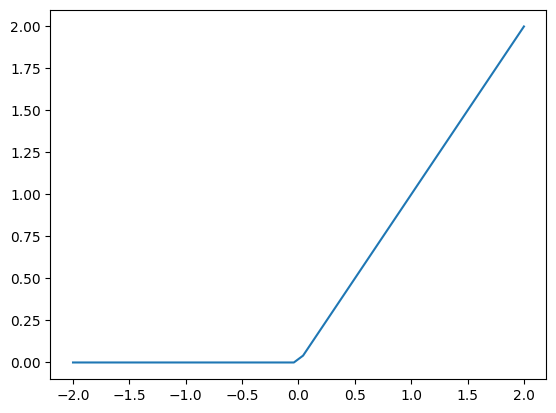

In [239]:
x_ample = np.linspace(-2, 2)
plt.plot(x_ample, nn.ReLU()(torch.tensor(x_ample, dtype=torch.float32)))
plt.show()

In [240]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 8),
            nn.ReLU(),
            nn.Linear(8, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        return self.model(x)

summary(SimpleNN(), input_size=(1, 1))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleNN                                 [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 8]                    16
│    └─ReLU: 2-2                         [1, 8]                    --
│    └─Linear: 2-3                       [1, 8]                    72
│    └─ReLU: 2-4                         [1, 8]                    --
│    └─Linear: 2-5                       [1, 1]                    9
Total params: 97
Trainable params: 97
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

## Loss Function, Optimizer, and Learning Rate

In order to train our model, we need to define a loss function and an optimizer. These two components are essential for the training process, as they determine how the model learns from the data. The loss function, also known as the `criterion` in PyTorch, measures how well the model is performing by comparing the model's predictions to the true values. The optimizer, on the other hand, is responsible for updating the model's parameters (the weights and biases) based on the gradients calculated from the loss function.

In this case, we're using the Mean Squared Error (MSE) loss function, which is a common choice for regression tasks. The MSE loss function calculates the average of the squared differences between the predicted values and the true values. The optimizer we're using is Adam, which is a popular choice for training neural networks due to its adaptive learning rate and ability to handle sparse gradients.

You also might notice that we pass an argument called `lr` to the optimizer. This is the learning rate, which is a hyperparameter that determines how much the model's parameters are updated at each step. A smaller learning rate means that the model will take smaller steps towards the optimal solution, while a larger learning rate means that the model will take larger steps. The learning rate is an important hyperparameter to tune, as it can greatly affect the model's performance and convergence speed.

Sometimes it can be tricky to find the right learning rate, as too small of a learning rate can lead to slow convergence, while too large of a learning rate can lead to overshooting the optimal solution and causing the model to diverge. In a lot of cases, it can be helpful to use a learning rate scheduler, which adjusts the learning rate during training based on the model's performance. This can help the model converge faster and achieve better performance.

In [241]:
# Initialize the model, loss function, and optimizer
model = SimpleNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Training the model

Now that we have our model, we can train it on our data! 
* In PyTorch, we train a model by writing a simple loop that passes the data through the model, calculates the loss, and then updates the model's parameters using the optimizer. There are a few hyperparameters we define to control the training process:
    * the `epochs` parameter to specify how many times the model should go through the entire training dataset. One epoch is one complete pass through all the samples in the training dataset. The more epochs, the more the model will learn, but too many epochs can lead to overfitting.
    * the `batch_size` parameter to specify how many samples the model should use to calculate the gradient at each step. This is part of the gradient descent process, where the model is updated after each batch of samples is passed through the network. Higher values of `batch_size` can help speed up training, but can also lead to a less stable model because the impact of each training sample is reduced, as it's being averaged out across a larger group.


* We also have to do a bit more data wrangling before we feed it into our training loop. Before we train, we need to split our data into a training set and a validation set. The training set is used to train the model, while the validation set is used to evaluate the model's performance during training. This helps us monitor the model's performance and prevent overfitting. In some more advanced cases, we can use the validation set to adjust the model's hyperparameters on the fly, such as the learning rate or the number of epochs, to prevent overfitting.
    * **"Why don't we just use the test data for this purpose?"** - The test data is used to evaluate the model's performance _after_ training is complete, and should not be used during training time to adjust any (hyper)parameters or make any decisions about the model. If we used the test data to adjust the model's parameters, we'd be at risk of overfitting/biasing our model to the test data itself, and we won't actually know how our model performs on totally new, unseen data.


* Additionally, in PyTorch, we have to use something called a *Dataloader*.
    * A dataloader is a PyTorch utility that helps us load our data in batches. It allows us to specify the batch size and shuffle the data, and generally handles the data loading process for us. This is especially useful when working with large datasets, as it allows us to load the data in smaller chunks and avoid running out of memory.
    * In this case, we're using a `TensorDataset` to create a dataset from our training data, and then using a `DataLoader` to create a dataloader from that dataset. The `DataLoader` will automatically handle batching and shuffling the data for us.
    * If you have a more complex dataset, you can also create a custom Dataset and/or Dataloader class. This allows you to define exactly how your data is loaded and processed, and gives you more control over the data loading process.
    * As a side note, we are only using a dataloader for the training dataset here, as the dataset is very small, and we don't need to shuffle the validation or test datasets. The validation and test datasets are used to evaluate the model's performance, and shuffling them would not make sense in this context. That being said, if you're working with a large dataset, you might want to use a dataloader for the validation and test datasets to make it easier to load and process the data without running out of memory when doing evaluation.

### How does training work?


![Gif of the basic training loop of a neural network](img/training_loop.gif)

The training process is a loop that repeats for a number of epochs, or iterations over our training dataset. The basic structuer of the training loop is as follows:
1. **Forward Pass**: The model takes the input data and passes it through the network to get a prediction.
2. **Loss Calculation**: The model compares the prediction to the true value and calculates a loss, a measure of how far off the prediction was from the true value. The loss is calculated over a number of samples/forward passes, equal to the `batch_size`, to reduce training time and improve stability.
3. **Backward Pass (Backpropagation)**: The model then calculates the gradient of the loss with respect to the model's parameters (the weights and biases of the network) using the chain rule of calculus. This gradient tells the model how much it should adjust each parameter to reduce the loss.
4. **Parameter Update**: The model then updates the parameters using the gradient, moving them in the direction that reduces the loss. This is done using an optimization algorithm, like Stochastic Gradient Descent (SGD) or Adam, which determines how much the parameters should be adjusted based on the gradient. 
5. **Repeat**: The model then repeats this process for the next batch of samples, and continues until it has gone through the entire training dataset. This completes one epoch. The model then repeats this process for the number of epochs specified, or until it's stopped by some other function that's monitoring the training loop.

In [242]:
# Perform train-test-validation split and convert the numpy data into PyTorch tensors

# Split the existing "train" data further into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# Convert the numpy arrays to PyTorch tensors so that we can use them in our model
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [243]:
epochs = 100
batch_size = 256
train_dataset = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(epochs):
    model.train() # Tell the model we're in training mode
    # Training step, iterating over the training data in batches
    for batch_x, batch_y in train_dataloader:
        optimizer.zero_grad() # Clear the gradients from the previous step
        outputs = model(batch_x) # Pass the input data through the model to get predictions
        loss = criterion(outputs, batch_y) # Calculate the loss between the predictions and the true values
        loss.backward() # Calculate the gradients of the loss with respect to the model's parameters
        optimizer.step() # Update the model's parameters using the optimizer

    # Validation step
    model.eval() # Tell the model we're in evaluation mode
    with torch.no_grad(): # Disable gradient calculation for validation, as we aren't updating the parameters of the model with the validation data
        val_outputs = model(x_val_tensor) # Pass the validation data through the model to get predictions
        val_loss = criterion(val_outputs, y_val_tensor) # Calculate the loss between the predictions and the true values
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}") # Report the metrics for this epoch

Epoch 1/100, Training Loss: 1123241.7500, Validation Loss: 1325869.0000
Epoch 2/100, Training Loss: 1122839.7500, Validation Loss: 1325431.2500
Epoch 3/100, Training Loss: 1122434.8750, Validation Loss: 1324989.2500
Epoch 4/100, Training Loss: 1121981.2500, Validation Loss: 1324484.1250
Epoch 5/100, Training Loss: 1121488.3750, Validation Loss: 1323940.5000
Epoch 6/100, Training Loss: 1120956.7500, Validation Loss: 1323334.6250
Epoch 7/100, Training Loss: 1120170.2500, Validation Loss: 1322445.0000
Epoch 8/100, Training Loss: 1119227.5000, Validation Loss: 1321404.6250
Epoch 9/100, Training Loss: 1118192.0000, Validation Loss: 1320267.5000
Epoch 10/100, Training Loss: 1117075.0000, Validation Loss: 1319042.1250
Epoch 11/100, Training Loss: 1115877.5000, Validation Loss: 1317729.0000
Epoch 12/100, Training Loss: 1114590.0000, Validation Loss: 1316317.0000
Epoch 13/100, Training Loss: 1113200.3750, Validation Loss: 1314792.5000
Epoch 14/100, Training Loss: 1111689.6250, Validation Loss: 

In [244]:
# Evaluate the model
with torch.no_grad(): # Disable gradient calculation for evaluation, as we aren't updating the parameters of the model with the test set
    predictions = model(x_test_tensor) # Pass the test data through the model to get predictions
    mae = mean_absolute_error(y_test, predictions.numpy()) # Calculate the Mean Absolute Error between the predictions and the true values
    print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 2089.211168162105


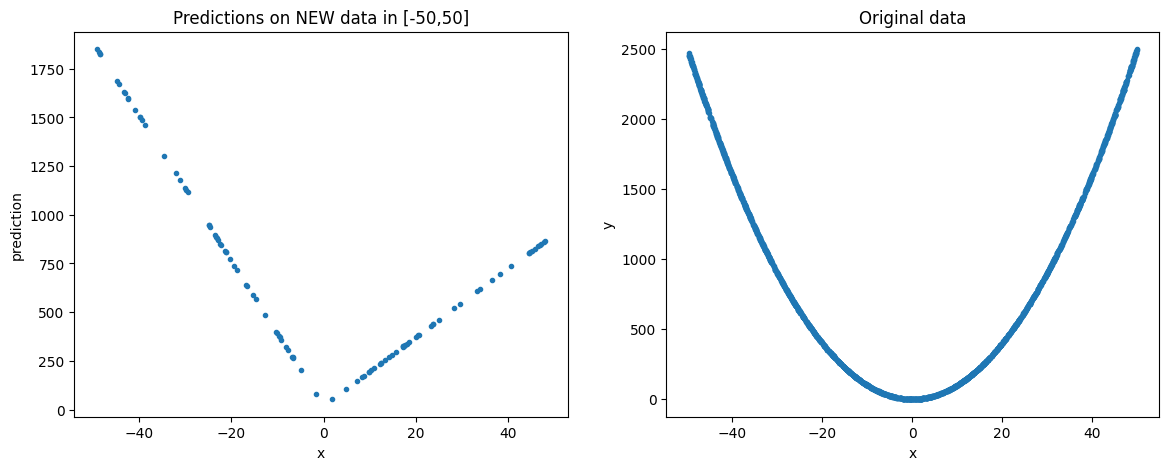

In [245]:
# Plot predictions
plt.figure(figsize=(14, 5)) # Setup our plot wiht a specific size
plt.subplot(1, 2, 1) # Create a subplot for the predictions
p = np.random.random((100, 1)) * 100 - 50 # Generate new data points in the range [-50, 50] to test the model's predictions
p_tensor = torch.tensor(p, dtype=torch.float32) # Convert the new data points to a PyTorch tensor
plt.plot(p, model(p_tensor).detach().numpy(), '.') # Plot the predictions of the model on new data, converting the output tensor back into a numpy array so that we can plot it
plt.xlabel('x')
plt.ylabel('prediction')
plt.title('Predictions on NEW data in [-50,50]')

# Plot the original data for comparison's sake
plt.subplot(1, 2, 2)
plt.xlabel('x')
plt.ylabel('y')
plt.plot(x_data, y_data, '.')
plt.title('Original data')
plt.show()

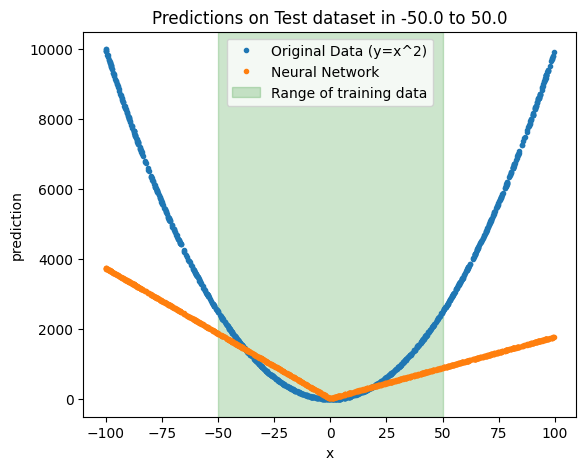

In [246]:
# Plot predictions on test data
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(x_test, y_test, ".", label="Original Data (y=x^2)")
plt.plot(x_test, predictions.numpy(), '.', label="Neural Network")
plt.axvspan(-50, 50, color='green', alpha=0.2, label="Range of training data")
plt.legend()
plt.xlabel('x')
plt.ylabel('prediction')
plt.title('Predictions on Test dataset in {} to {}'.format(-(train_range / 2), (train_range / 2)))
plt.show()

## Improving Performance    
You might notice that our model isn't _quite_ getting what we hoped it'd learn. This means our work isn't quite done yet, but thankfully there's a few things we can easily try to improve the performance of our model. 

## Bigger layers and more layers

Increasing layer size and adding more layers to a model can help it learn more complex patterns in the data. By giving each layer more neurons, we're giving the a layer more "capacity" (or "width") to learn different features of our dataset at that point in the network. By adding more layers, we're giving the model more "depth", allowing it to understand more complex relationships between the features of our dataset.

Both make training and inference slightly more complicated (more calculations have to be done, roughly measured by the number of parameters in the model), but it also lets the model get better results for more complicated data.

We increase the size of the model by changing the unit size in the Linear (dense) layer.
[You can take a look at the Linear layer documentation here.](https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html)

### Challenge
In the example below, try increasing the size of the layers from 8, and try adding more layers to the model. See how well you can get the model to perform, evaluating its performance on the test dataset through the Mean Absolute Error and the plots printed below. 
The units are just the number of points in the matrix of the dense layer. 

### Bonus Challenge
As a bonus challenge, try to get the model to under 1000 Mean Absolute Error on the test data, only training for 100 epochs, with the smallest number of parameters possible (this is printed out in the table below the model summary!) 

Hint: If you get stuck, you can try lowering the batch size, too!



In [247]:
class BiggerSimpleNN(nn.Module):
    def __init__(self):
        super(BiggerSimpleNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(1,128), # The first layer's input size should match the size of the input data, and the output size can be whatever you want it to be (this is the "width", or the number of neurons in the layer)
            nn.ReLU(), # Make sure to add an activation function after each layer!
            nn.Linear(128, 32), # The next layer's input size should match the output size of the previous layer, and the output size can be whatever you want it to be
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 256),
            nn.ReLU(),
            # Add or remove layers if you'd like!
            nn.Linear(256, 1) # The last layer's input size should match the output size of the previous layer, and the output size should be 1, as we're predicting a single value (y)
        )

    def forward(self, x):
        return self.model(x)



bigger_model = BiggerSimpleNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(bigger_model.parameters(), lr=0.001)

summary(BiggerSimpleNN(), input_size=(1, 1))

Layer (type:depth-idx)                   Output Shape              Param #
BiggerSimpleNN                           [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 128]                  256
│    └─ReLU: 2-2                         [1, 128]                  --
│    └─Linear: 2-3                       [1, 32]                   4,128
│    └─ReLU: 2-4                         [1, 32]                   --
│    └─Linear: 2-5                       [1, 32]                   1,056
│    └─ReLU: 2-6                         [1, 32]                   --
│    └─Linear: 2-7                       [1, 256]                  8,448
│    └─ReLU: 2-8                         [1, 256]                  --
│    └─Linear: 2-9                       [1, 1]                    257
Total params: 14,145
Trainable params: 14,145
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.01
Input size (MB): 0.00
Forward/back

In [248]:
epochs = 100
batch_size = 32
train_dataset = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(epochs):
    bigger_model.train() # Tell the model we're in training mode
    # Training step, iterating over the training data in batches
    for batch_x, batch_y in train_dataloader:
        optimizer.zero_grad() # Clear the gradients from the previous step
        outputs = bigger_model(batch_x) # Pass the input data through the model to get predictions
        loss = criterion(outputs, batch_y) # Calculate the loss between the predictions and the true values
        loss.backward() # Calculate the gradients of the loss with respect to the model's parameters
        optimizer.step() # Update the model's parameters using the optimizer

    # Validation step
    bigger_model.eval() # Tell the model we're in evaluation mode
    with torch.no_grad(): # Disable gradient calculation for validation, as we aren't updating the parameters of the model with the validation data
        val_outputs = bigger_model(x_val_tensor) # Pass the validation data through the model to get predictions
        val_loss = criterion(val_outputs, y_val_tensor) # Calculate the loss between the predictions and the true values
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}") # Report the validation loss for this epoch

Epoch 1/100, Training Loss: 196775.5625, Validation Loss: 180402.9375
Epoch 2/100, Training Loss: 85463.1172, Validation Loss: 75997.9141
Epoch 3/100, Training Loss: 83287.6719, Validation Loss: 75322.0625
Epoch 4/100, Training Loss: 81791.5625, Validation Loss: 74041.2812
Epoch 5/100, Training Loss: 80605.9531, Validation Loss: 72824.8516
Epoch 6/100, Training Loss: 79490.4375, Validation Loss: 71535.7734
Epoch 7/100, Training Loss: 78373.4531, Validation Loss: 70221.8516
Epoch 8/100, Training Loss: 77047.5547, Validation Loss: 68935.5469
Epoch 9/100, Training Loss: 75562.2578, Validation Loss: 67506.7188
Epoch 10/100, Training Loss: 74181.3281, Validation Loss: 65943.7969
Epoch 11/100, Training Loss: 71981.0938, Validation Loss: 64202.4766
Epoch 12/100, Training Loss: 69491.7812, Validation Loss: 61825.0391
Epoch 13/100, Training Loss: 66506.0000, Validation Loss: 59329.0781
Epoch 14/100, Training Loss: 62797.9219, Validation Loss: 56256.7500
Epoch 15/100, Training Loss: 58627.4219, 

In [249]:
# Evaluate the model
bigger_model.eval()
with torch.no_grad():
    bigger_predictions = bigger_model(x_test_tensor) # Pass the test data through the model to get predictions
    mae = mean_absolute_error(y_test, bigger_predictions.numpy()) # Calculate the Mean Absolute Error between the predictions and the true values
    print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 715.3699685509035


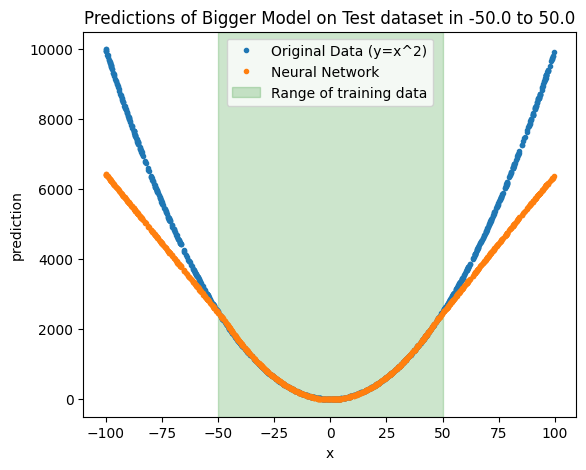

In [250]:
# Plot bigger_predictions on test data
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(x_test, y_test, ".", label="Original Data (y=x^2)")
plt.plot(x_test, bigger_predictions.numpy(), '.', label="Neural Network")
plt.axvspan(-50, 50, color='green', alpha=0.2, label="Range of training data")
plt.legend()
plt.xlabel('x')
plt.ylabel('prediction')
plt.title('Predictions of Bigger Model on Test dataset in {} to {}'.format(-(train_range / 2), (train_range / 2)))
plt.show()

### One final note before moving on 
You might've noticed that regardless of what we've done to the model, it's performance on the test data that falls outside the range of it's training data is pretty poor. This is a common issue with neural networks, especially simple dense networks like the one's we've been playing with, and is a good example of how they can struggle with extrapolation. Remember that neural networks _only_ possess the context and information that it's learned from it's training dataset. If the model hasn't seen data that's similar to what it's being asked to predict, it's going to struggle to make accurate predictions. This is why it's important to have a diverse and representative training dataset, and to be aware of the limitations of your model when you're using it to make predictions. Neural networks aren't magic, all knowing, or the answer to all of our problems (despite what silicon valley might otherwise want you to believe ;) ), but they are still an incredibly useful tool to have in your toolbox.

# Classification tasks with neural networks

So far, we've been looking at regression tasks, where the output of our model is a continuous value. But what if we want to classify our data into different categories? This is what we (unsurprisingly) call a classification task! In this case, we have make a few modifications to our model and training:

    * We have to change the output of our model to give us a probability distribution over the different classes
    * We have to use a different loss function to train our model
    * We have to use different metrics to evaluate our model (seperately from the loss function)
    
### Binary Classification vs Multi-Class Classification
There are two fundimental types of classification problems - Binary and Multi-Class. In a binary classification problem, we're trying to classify data into one of two classes, while in a multi-class classification problem, we're trying to classify data into one of many classes. We make this distinction because the way we set up our model and the way we evaluate it can change depending on the number of classes we're trying to predict. In this case, we have 5 classes, so we're doing a multi-class classification task.

### Softmax Activation
In a multi-class classification task, the output of our model is typically a probability distribution over the different classes. To do this, we set our output layer to have the same number of neurons of classes that we have, and for it's activation function, we use the **Softmax Activation Function**. The softmax function takes the raw output of our model and squashes it into a probability distribution, where the sum of the probabilities of each class is equal to 1. This allows us to interpret the outputs of our model as the percentage chance that a given input belongs to each class.

### Categorical Crossentropy Loss
To train a model for a multi-class classification task, we use a loss function called **Categorical Crossentropy**. This loss function compares the probability distribution output by our model to the true distribution of the data, and calculates a loss based on how far off the model's prediction is from the true value. Just like before, the goal of training the model is to minimize its loss so that the model's predictions are as close to the true values as possible.

### Metrics
When evaluating a model for a classification task, we typically use a few different metrics to understand how well the model is performing. Some common metrics include:
* **Accuracy**: The overall ratio of correct guesses/total guesses. 100% is perfect, and 100/number of classes (so in our particle physics example case, 100/5 classes = 20%) is "worst case", 
as it's statistically no better than picking a label at random.
* **Confusion Matrix**: This is a specific kind of plot that shows how many samples of a given class were predicted as what, for every class. The axis of this plot are "True" and "Predicted",
usually showing the number or percentage of the samples guessed as such in each cell of the plot. This shows a more detailed breakdown of what the model is guessing, and where it might be confusing two or more classes
* **Receiver Operating Characteristic curve aka ROC curve**: This is a plot of the true positive rate (sensitivity) vs the false positive rate (1-specificity) for a binary classification task. 
It shows how well the model is able to distinguish between the two classes, and is a good way to evaluate the performance of a binary classifier. In the case of a multi-class classifier, 
we can plot a ROC curve for each class against all the others, or use a One-vs-All approach to plot a single ROC curve for the entire model.
* **(ROC) Area Under the Curve, aka (ROC)AUC**: This is simply a way to distill the ROC into a single value, and as the name implies, is effectively just taking the integral of the ROC curve. 
100% is the best case scenerio, and 50% is the worst case scenerio.


## Particle Physics Example: Jet Tagging

<img src="img/jet_tagger_jets.png" alt="2D Representations of the different kinds of particle jets the neural network will classify" style="background-color:white; width: 800px;"/>

In this example, we'll be looking at a "simple" high energy physics task - **Jet Tagging**

In a particle collider, Jets are sprays of hadrons produced in very high-energy particle collisions. We're interested in determining what kind of particle produced a given jet. As the above image shows, we have 5 different kinds of jets that we want to classify (tag).

We have 16 **features**, that we have measured and/or calculated from collisions in the Large Hadron Collider that we will feed into our neural network, asking it to guess which one of the 5 possible particles was responsible for a given jet.  

### Multi-Layer Perceptron - Your first Deep Neural Network!

<img src="img/jet_tagger_mlp.png" alt="Graph of the Jet Tagger MLP Neural Network" style="background-color:white; width: 400px;"/>

The neural network that we're going to use to accomplish this is what we call a 3 **hidden layer** network, meaning there are 3 layers of neurons "hidden" between the input and the output of the network.

But, we still have some work to do before building and training our network!

In [251]:
#Import some tensorflow tools we need
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [252]:
# load the dataset
data = jet_tagging_data
X, y = data['data'], data['target']

In [253]:
# look at some example data
print(data['feature_names'])
print(X.shape, y.shape)
print(X[:5])
print(y[:5])

['zlogz', 'c1_b0_mmdt', 'c1_b1_mmdt', 'c1_b2_mmdt', 'c2_b1_mmdt', 'c2_b2_mmdt', 'd2_b1_mmdt', 'd2_b2_mmdt', 'd2_a1_b1_mmdt', 'd2_a1_b2_mmdt', 'm2_b1_mmdt', 'm2_b2_mmdt', 'n2_b1_mmdt', 'n2_b2_mmdt', 'mass_mmdt', 'multiplicity']
(830000, 16) (830000,)
      zlogz  c1_b0_mmdt  c1_b1_mmdt  c1_b2_mmdt  c2_b1_mmdt  c2_b2_mmdt  \
0 -2.935125    0.383155    0.005126    0.000084    0.009070    0.000179   
1 -1.927335    0.270699    0.001585    0.000011    0.003232    0.000029   
2 -3.112147    0.458171    0.097914    0.028588    0.124278    0.038487   
3 -2.666515    0.437068    0.049122    0.007978    0.047477    0.004802   
4 -2.484843    0.428981    0.041786    0.006110    0.023066    0.001123   

   d2_b1_mmdt  d2_b2_mmdt  d2_a1_b1_mmdt  d2_a1_b2_mmdt  m2_b1_mmdt  \
0    1.769445    2.123898       1.769445       0.308185    0.135687   
1    2.038834    2.563099       2.038834       0.211886    0.063729   
2    1.269254    1.346238       1.269254       0.246488    0.115636   
3    0.966505  

## Data pre-processing
As it stands, our data isn't quite ready to feed into a network. We need to do a little bit of work ahead of time (**preprocessing**) to format the data and apply some statistical methods to make things easier for the network to understand.

### Scaling Data

When training a model, the model needs to understand what things mean physically. Unfortunately, all they model knows is numbers. Because of this, a variable that has a very large scale will get undue importance according to the model. Because of this, we can scale the input to a range that is consistent between all the variables in the model.
In this scale, we'll do it by scaling according to the mean and standard deviation of the variable; using a `StandardScaler`

The standard scaler transforms variables according to the formula:

$$ X_{scaled} = \frac{(X_{original} - \mu)}{ \sigma }$$

### Label Encoding

Models cannot natively understand strings (words, letters, etc), only numbers. Because of this, we need to give them a little bit of help by encoding labels. In Pytorch, we use Integer Encoding, which is a way of converting categorical labels into a numerical format. This is done by assigning each unique label a unique integer index. For example, if we have 5 classes, we can assign them the indices 0, 1, 2, 3, and 4.

To do this, we use a package called `sklearn`, which has a `LabelEncoder` to convert the labels into this integer encoded format.


In [254]:
# Encode labels as integer indices
le = LabelEncoder()
y_indices = le.fit_transform(y)  # y is your original label array

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # X is your feature array

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_indices, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Convert to tensors
x_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
x_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

## Writing our Classification MLP in PyTorch

We'll define our MLP using a `functional` api this time. This means we'll define the model as seperate objects within the larger neural network class, and connect them together in the forward pass function. This is a bit more flexible than the `Sequential` API we used before, and allows us to define more complex models with multiple inputs and outputs, or models that have different architectures for different parts of the network.

The model is built out of 3 dense layers with an activation (ReLU) between each of them. Note that when using the functional API, we define the activation functions used within the `forward` method.

In [255]:
import torch.nn.functional as F

# Define the classification model using the functional API
class ClassificationNN(nn.Module):
    def __init__(self):
        super(ClassificationNN, self).__init__()
        self.fc1 = nn.Linear(16, 64) # Input Layer, the input size should match the number of features in the dataset
        self.fc2 = nn.Linear(64, 32) # Hidden Layer 1
        self.fc3 = nn.Linear(32, 32) # Hidden Layer 2
        self.fc4 = nn.Linear(32, 5) # Output Layer, with 5 output neurons for the 5 classes we want to predict

    def forward(self, x): # Our forward pass function takes a single parameter, the input data
        x = F.relu(self.fc1(x)) # we pass the input data through the first layer and apply the ReLU activation function
        x = F.relu(self.fc2(x)) # we do the same thing for the second layer
        x = F.relu(self.fc3(x)) # and the third layer
        x = self.fc4(x) # In PyTorch, the last layer does not need a softmax activation function, as we will apply it later in the loss function
        return x


## Training our Classification MLP

To train the model, we define the training optimizer (how the weights will be updated, we'll use Adam again), the loss being used (this is a classifier model, so we'll use a classifier loss called Cross Entropy), and the data being used to train it.

In [256]:
# Initialize the model, loss function, and optimizer
classification_model = ClassificationNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classification_model.parameters(), lr=0.0001)

In [257]:
epochs = 10
batch_size = 1024

train_dataset = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(x_val_tensor, y_val_tensor)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(epochs):
    # Training phase
    classification_model.train()
    total_train_loss = 0
    for batch_x, batch_y in train_dataloader:
        optimizer.zero_grad()
        outputs = classification_model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # Validation phase
    classification_model.eval()
    total_val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for val_x, val_y in val_dataloader:
            val_outputs = classification_model(val_x)
            val_loss = criterion(val_outputs, val_y)
            total_val_loss += val_loss.item()
            preds = torch.argmax(val_outputs, dim=1)
            correct += (preds == val_y).sum().item()
            total += val_y.size(0)

    avg_train_loss = total_train_loss / len(train_dataloader)
    avg_val_loss = total_val_loss / len(val_dataloader)
    val_accuracy = correct / total

    print(f"Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss:.4f}, "
          f"Average Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%")

Epoch 1/10, Average Training Loss: 1.3775, Average Validation Loss: 1.1064, Validation Accuracy: 58.35%
Epoch 2/10, Average Training Loss: 1.0185, Average Validation Loss: 0.9645, Validation Accuracy: 65.95%
Epoch 3/10, Average Training Loss: 0.9307, Average Validation Loss: 0.8967, Validation Accuracy: 69.65%
Epoch 4/10, Average Training Loss: 0.8659, Average Validation Loss: 0.8390, Validation Accuracy: 71.64%
Epoch 5/10, Average Training Loss: 0.8225, Average Validation Loss: 0.8094, Validation Accuracy: 72.20%
Epoch 6/10, Average Training Loss: 0.8006, Average Validation Loss: 0.7938, Validation Accuracy: 72.52%
Epoch 7/10, Average Training Loss: 0.7876, Average Validation Loss: 0.7835, Validation Accuracy: 72.81%
Epoch 8/10, Average Training Loss: 0.7780, Average Validation Loss: 0.7756, Validation Accuracy: 72.99%
Epoch 9/10, Average Training Loss: 0.7696, Average Validation Loss: 0.7671, Validation Accuracy: 73.17%
Epoch 10/10, Average Training Loss: 0.7617, Average Validation L

## Check model performance

Now that we've trained our model, we need to check and verify how well it does!
To do this, we first will be calculating all these performance numbers based on a **Test Set** of data we specifically held out from the training dataset.

We can, and should, use multiple different metrics to evaluate how well our model does. **One metric is not enough to sufficiently represent how our model does!!**

Specifically, we're going to look at:
* **Accuracy**: The overall ratio of correct guesses/total guesses. 100% is perfect, and 100/number of classes (so in our particle physics example case, 100/5 classes = 20%) is "worst case", 
as it's statistically no better than picking a label at random.
* **Confusion Matrix**: This is a specific kind of plot that shows how many samples of a given class were predicted as what, for every class. The axis of this plot are "True" and "Predicted",
usually showing the number or percentage of the samples guessed as such in each cell of the plot. This shows a more detailed breakdown of what the model is guessing, and where it might be confusing two or more classes
* **Receiver Operating Characteristic curve aka ROC curve**: This is a plot of the true positive rate (sensitivity) vs the false positive rate (1-specificity) for a binary classification task. 
It shows how well the model is able to distinguish between the two classes, and is a good way to evaluate the performance of a binary classifier. In the case of a multi-class classifier, 
we can plot a ROC curve for each class against all the others, or use a One-vs-All approach to plot a single ROC curve for the entire model.
* **(ROC) Area Under the Curve, aka (ROC)AUC**: This is simply a way to distill the ROC into a single value, and as the name implies, is effectively just taking the integral of the ROC curve. 
100% is the best case scenerio, and 50% is the worst case scenerio.




In [258]:
from sklearn.metrics import auc, roc_curve
import pandas as pd


def plotRoc(fpr, tpr, auc, labels, linestyle, legend=True):
    for _i, label in enumerate(labels):
        plt.plot(
            tpr[label],
            fpr[label],
            label='{} tagger, AUC = {:.1f}%'.format(label.replace('j_', ''), auc[label] * 100.0),
            linestyle=linestyle,
        )
    plt.semilogy()
    plt.xlabel("Signal Efficiency")
    plt.ylabel("Background Efficiency")
    plt.ylim(0.001, 1)
    plt.grid(True)
    if legend:
        plt.legend(loc='upper left')
    plt.figtext(0.25, 0.90, 'Classification Performance', fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)


def rocData(y, predict_test, labels):
    df = pd.DataFrame()

    fpr = {}
    tpr = {}
    auc1 = {}

    for i, label in enumerate(labels):
        df[label] = y[:, i].cpu().numpy()  # Convert PyTorch tensor to numpy
        df[label + '_pred'] = predict_test[:, i].cpu().numpy()  # Convert PyTorch tensor to numpy

        fpr[label], tpr[label], threshold = roc_curve(df[label], df[label + '_pred'])

        auc1[label] = auc(fpr[label], tpr[label])
    return fpr, tpr, auc1

def makeRoc(y, predict_test, labels, linestyle='-', legend=True):
    if 'j_index' in labels:
        labels.remove('j_index')

    fpr, tpr, auc1 = rocData(y, predict_test, labels)
    plotRoc(fpr, tpr, auc1, labels, linestyle, legend=legend)
    return predict_test


Test Accuracy: 73.19%


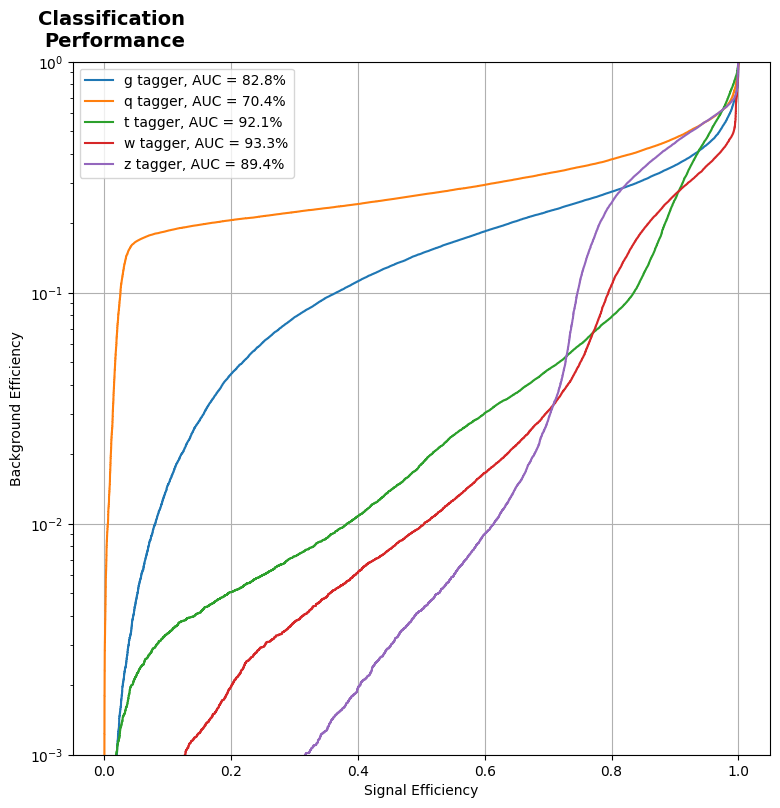

In [259]:
# Evaluate the model
classification_model.eval()
with torch.no_grad():
    test_outputs = classification_model(x_test_tensor)
    test_predictions = torch.argmax(test_outputs, axis=1)
    test_accuracy = sklearn.metrics.accuracy_score(y_test_tensor.numpy(), test_predictions.numpy())

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# For ROC, convert y_test_tensor to one-hot
y_test_onehot = torch.nn.functional.one_hot(y_test_tensor, num_classes=5).float()

plt.figure(figsize=(9, 9))
_ = makeRoc(y_test_onehot, test_outputs, le.classes_)
plt.show()

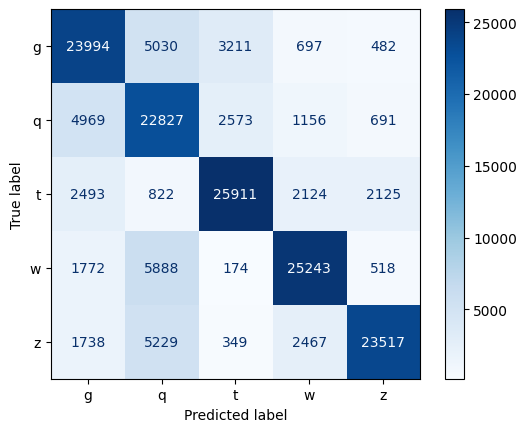

In [260]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test_tensor.numpy(), test_predictions.numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## Group Project: Build and train your own classification model!

Now that you've seen how to build and train a classification model, it's your turn to build your own!
We'll be using the [MAGIC dataset](https://archive.ics.uci.edu/dataset/159/magic+gamma+telescope) for this project, which is a dataset of gamma-ray and hadron events from a gamma-ray telescope. The goal is to classify the events into one of two classes: gamma-ray or hadron. The dataset has 10 features, which are the measurements taken by the telescope, and a target variable which is the class label (gamma-ray or hadron). See if you can build a model that can classify the events with an accuracy of at least 85% on the test set!

We'll be using the same steps as before, but this time you'll be building the model yourself. You'll need to:
1. Load the dataset and preprocess it (scale the features, encode the labels, split into training and test sets)
2. Define the model architecture (you can use similar architectures as before, or try something different!)
3. Define the loss function and optimizer, along with other hyperparameters (learning rate, batch size, number of epochs, etc.)
3. Train the model
4. Evaluate the model on the test set and report the accuracy, confusion matrix, and ROC curve

Work together to test different preprocessing strategies, architectures, hyperparameters, and training strategies to see how well you can get the model to perform. Try different options in parallel, then report back to your group members and colaborate to find a combination that produces a well performing model. Remember to use the same evaluation metrics as before, and try to beat the 85% accuracy threshold!

At the end of the time alocated, you'll present your model and results to the class, explaining the choices you made and how they affected the performance of the model. We'll compare the different models and see which one performed the best, and discuss what worked well and what didn't.

For the sake of easy results presentation, please create a slide or two in the following google slides presentation: [Google Slides Presentation](https://docs.google.com/presentation/d/1bswjHnkkto1bDRIXUFCJF2AEwZXJVZIT8HFxK9em22o/edit?usp=sharing) with screenshots of your model architecture, training results, and evaluation metrics.


## Loading and Preprocessing the MAGIC Dataset

First, we'll load the dataset from a website called OpenML, which is a repository of machine learning datasets. We'll use the `fetch_openml` function from `sklearn.datasets` to load the dataset. Once we have the dataset, you'll need to preprocess it in a similar way to how we did with the jet tagging dataset. This includes scaling the features, encoding the labels, and splitting the dataset into training, validation, and test sets.



In [268]:
# Load the MAGIC dataset
magic_data = fetch_openml(data_id=1120, as_frame=True)

# Extract features and target variable
X_magic = magic_data.data
y_magic = magic_data.target

# Visualize the dataset a bit
print("Features:", X_magic.columns.tolist())
print("Number of samples:", X_magic.shape[0])
print(X_magic[:5])
print(y_magic[:5])

# Split the dataset into training and test sets (Pass the random_state=42 argument with the train_test_split function for reproducibility)
x_train_magic, x_test_magic, y_train_magic, y_test_magic = train_test_split(X_magic, y_magic, test_size=0.2, random_state=42)

# Preprocess the MAGIC dataset

# Scale the features using StandardScaler
scaler_magic = StandardScaler()
x_train_magic = scaler_magic.fit_transform(x_train_magic)  # Fit and transform the training data
x_test_magic = scaler_magic.transform(x_test_magic)  # Transform the test data using the same scaler

# Encode the target variable using LabelEncoder
label_encoder_magic = LabelEncoder()
y_train_magic = label_encoder_magic.fit_transform(y_train_magic)  # Fit and transform the training labels
y_test_magic = label_encoder_magic.transform(y_test_magic)

# Split the training data into training and validation sets
x_train_magic, x_val_magic, y_train_magic, y_val_magic = train_test_split(x_train_magic, y_train_magic, test_size=0.25, random_state=42)

# Convert the data into PyTorch tensors
x_train_tensor_magic = torch.tensor(x_train_magic, dtype=torch.float32)
y_train_tensor_magic = torch.tensor(y_train_magic, dtype=torch.long)  # Use long for class indices
x_val_tensor_magic = torch.tensor(x_val_magic, dtype=torch.float32)
y_val_tensor_magic = torch.tensor(y_val_magic, dtype=torch.long)
x_test_tensor_magic = torch.tensor(x_test_magic, dtype=torch.float32)
y_test_tensor_magic = torch.tensor(y_test_magic, dtype=torch.long)

print(x_train_tensor_magic[:5])  # Print the first 5 rows of the training data tensor
print(y_train_tensor_magic[:5])  # Print the first 5 labels of the training data tensor

# Your code here!

Features: ['fLength:', 'fWidth:', 'fSize:', 'fConc:', 'fConc1:', 'fAsym:', 'fM3Long:', 'fM3Trans:', 'fAlpha:', 'fDist:']
Number of samples: 19020
   fLength:   fWidth:  fSize:  fConc:  fConc1:    fAsym:  fM3Long:  fM3Trans:  \
0   28.7967   16.0021  2.6449  0.3918   0.1982   27.7004   22.0110    -8.2027   
1   31.6036   11.7235  2.5185  0.5303   0.3773   26.2722   23.8238    -9.9574   
2  162.0520  136.0310  4.0612  0.0374   0.0187  116.7410  -64.8580   -45.2160   
3   23.8172    9.5728  2.3385  0.6147   0.3922   27.2107   -6.4633    -7.1513   
4   75.1362   30.9205  3.1611  0.3168   0.1832   -5.5277   28.5525    21.8393   

   fAlpha:    fDist:  
0  40.0920   81.8828  
1   6.3609  205.2610  
2  76.9600  256.7880  
3  10.4490  116.7370  
4   4.6480  356.4620  
0    g
1    g
2    g
3    g
4    g
Name: class:, dtype: category
Categories (2, object): ['g', 'h']
tensor([[-0.7713, -0.6938, -0.6118,  1.2679,  1.5591,  0.1400, -0.5085, -0.4970,
          2.0492, -1.1981],
        [ 0.3671,  0

## Building the Classification Model

Now that we have preprocessed the MAGIC dataset, we can build our classification model. Feel free to start with a similar architecture to the one we used for the jet tagging task, or try something different! The output layer should have 2 neurons (one for each class).

Feel free to use the `nn.Sequential` API or the functional API, depending on your preference. Remember to include activation functions between the layers in the proper places.

In [281]:
# Build your model here, either using the Sequential API or the Functional API

class MagicNN(nn.Module):
    def __init__(self):
        super(MagicNN, self).__init__()
        # do self.model = nn.Sequential(...) if using Sequential API, otherwise define each layer as a separate attribute (self.fc1, self.fc2, etc.) and call them in the forward method
        self.fc1 = nn.Linear(10, 256)  # Input layer, input size should match the number of features in the dataset
        self.fc2 = nn.Linear(256, 256)  # Hidden layer 1
        self.fc3 = nn.Linear(256, 128)  # Hidden layer 2
        self.fc4 = nn.Linear(128, 128)  # Hidden layer 3
        self.fc5 = nn.Linear(128, 64)   # Hidden layer 4
        self.fc6 = nn.Linear(64, 32)    # Hidden layer 5
        self.fc7 = nn.Linear(32, 2)   # Output layer, with 2 output neurons for the 2 classes we want to predict
        # Add activation functions as needed, or use functional API in the forward method

        # Add your layers here

    def forward(self, x): # Our forward pass function takes a single parameter, the input data
        x = F.relu(self.fc1(x)) # we pass the input data through the first layer and apply the ReLU activation function
        x = F.relu(self.fc2(x)) # we do the same thing for the second layer
        x = F.relu(self.fc3(x)) # and the third layer
        x = F.relu(self.fc4(x)) # etc.
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = self.fc7(x) # Finally, we apply the softmax activation function to the output layer to get a probability distribution over the classes
        return x  # return the output of the model
        # return x if doing functional API, or self.model(x) if using Sequential API

## Training the Classification Model

Now that we have defined our model, we can train it using the same steps as before. We'll define the loss function, the optimizer and the hyperparameters (learning rate, batch size, number of epochs, etc.). Then we'll train the model on the training set and validate it on the validation set.

In [282]:
# Initialize the model, loss function, and optimizer
magic_model = MagicNN()
criterion = nn.CrossEntropyLoss()  # Use Binary Cross Entropy Loss for classification
optimizer = optim.Adam(magic_model.parameters(), lr=0.0001)

In [283]:
# Set the number of epochs and batch size for training
epochs = 100
batch_size = 1024

# Create DataLoader for training and validation datasets
train_dataset = torch.utils.data.TensorDataset(x_train_tensor_magic, y_train_tensor_magic)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(x_val_tensor_magic, y_val_tensor_magic)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Train the model
for epoch in range(epochs):
    # Training phase
    magic_model.train()
    total_train_loss = 0
    for batch_x, batch_y in train_dataloader:
        optimizer.zero_grad()
        outputs = magic_model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # Validation phase
    magic_model.eval()
    total_val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for val_batch_x, val_batch_y in val_dataloader:
            val_outputs = magic_model(val_batch_x)
            val_loss = criterion(val_outputs, val_batch_y)
            total_val_loss += val_loss.item()
            val_predictions = torch.argmax(val_outputs, axis=1)
            correct += (val_predictions == val_batch_y).sum().item()
            total += val_batch_y.size(0)

    avg_train_loss = total_train_loss / len(train_dataloader)
    avg_val_loss = total_val_loss / len(val_dataloader)
    val_accuracy = correct / total

    print(f"Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss:.4f}, "
          f"Average Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%")

Epoch 1/100, Average Training Loss: 0.6895, Average Validation Loss: 0.6865, Validation Accuracy: 65.01%
Epoch 2/100, Average Training Loss: 0.6843, Average Validation Loss: 0.6804, Validation Accuracy: 66.06%
Epoch 3/100, Average Training Loss: 0.6770, Average Validation Loss: 0.6713, Validation Accuracy: 69.95%
Epoch 4/100, Average Training Loss: 0.6650, Average Validation Loss: 0.6553, Validation Accuracy: 72.79%
Epoch 5/100, Average Training Loss: 0.6436, Average Validation Loss: 0.6265, Validation Accuracy: 76.18%
Epoch 6/100, Average Training Loss: 0.6076, Average Validation Loss: 0.5775, Validation Accuracy: 78.71%
Epoch 7/100, Average Training Loss: 0.5532, Average Validation Loss: 0.5124, Validation Accuracy: 79.21%
Epoch 8/100, Average Training Loss: 0.4890, Average Validation Loss: 0.4582, Validation Accuracy: 79.65%
Epoch 9/100, Average Training Loss: 0.4440, Average Validation Loss: 0.4303, Validation Accuracy: 80.55%
Epoch 10/100, Average Training Loss: 0.4232, Average Va

## Evaluating the Classification Model

With our model training finished, we can evaluate it on the test set. We'll calculate the accuracy, confusion matrix, and ROC curve for the model's predictions on the test set.

Test Accuracy: 86.93%


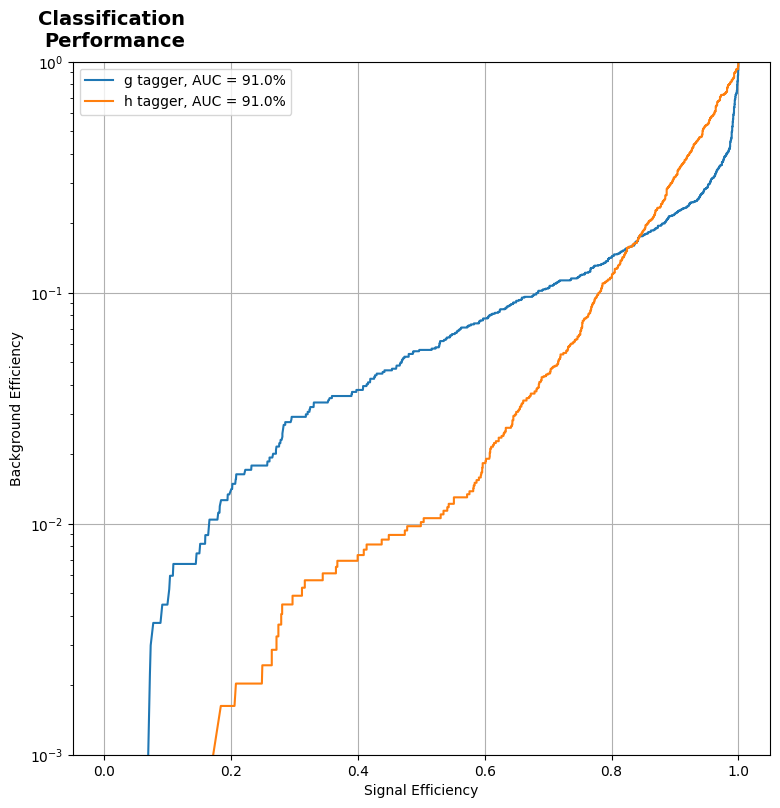

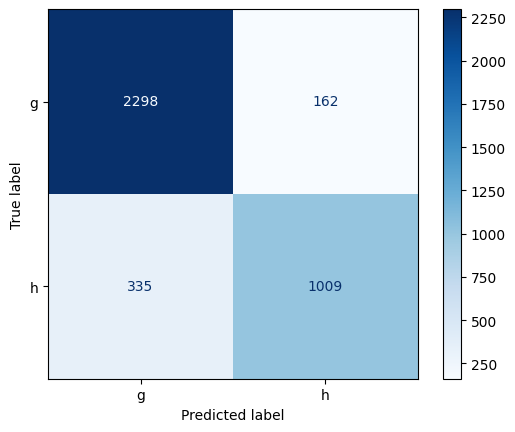

In [267]:
magic_model.eval()
with torch.no_grad():
    test_outputs = magic_model(x_test_tensor_magic)
    test_predictions = torch.argmax(test_outputs, axis=1)
    test_accuracy = sklearn.metrics.accuracy_score(y_test_tensor_magic.numpy(), test_predictions.numpy())

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# For ROC, convert y_test_tensor_magic to one-hot with 2 classes
y_test_onehot_magic = torch.nn.functional.one_hot(y_test_tensor_magic, num_classes=2).float()

plt.figure(figsize=(9, 9))
_ = makeRoc(y_test_onehot_magic, test_outputs, label_encoder_magic.classes_)
plt.show()

# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test_tensor_magic.numpy(), test_predictions.numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder_magic.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## Attribution, Sources, and Credits

This notebook was derived from two, seperate notebooks from the Tokyo Institute of Technology's ART.T458: Advanced Machine Learning course, and were originally authored by Prof. Naoaki Okazaki.

The original notebooks (and accompanying material) can be found here: https://chokkan.github.io/deeplearning/

The Jet Tagging MLP portion was adapted from [the hls4ml tutorial part 1 notebook](https://github.com/fastmachinelearning/hls4ml-tutorial/blob/main/part1_getting_started.ipynb)

Modifications to this notebook were done by Ben Hawks for the 2023-2025 Fermilab and Brookhaven National Lab Summer Exchange School

Various sources for images and other materials used is listed below:
1. [Matrix Transpose Gif by Lucas Vieira via Wikipedia](https://commons.wikimedia.org/wiki/File:Matrix_transpose.gif)
2. [Vector Components Image by LAKschool](https://lakschool.com/en/math/vectors/vector-length-or-magnitude)
3. [Backpropogation Gif by machinelearningknowledge.ai](https://machinelearningknowledge.ai/wp-content/uploads/2019/10/Backpropagation.gif)


## Appendix - Math and Definitions  

## Notation, Terms, and other background info
In this notebook, you'll likely see some new symbols, terminology, and other topics that you haven't come across before. Don't be afraid!

Most of the math symbols you see here simply function as *shorthand* for different math concepts, so that we can write an equation using these concepts without needing to define "generic" variables or functions every time we reference them. We've compiled a list of these terms here for you to reference when needed, but at least skimming through these before continuing is reccomended.

Additionally, there are some math concepts that are useful to know about/have a basic understanding of, as they're used quite heavily in this notebook (and Neural Networks/Machine Learning in general!)

We're going to assume that you have a baseline level of knowledge regarding some math concepts, but if you run into something that you don't understand (regardless of if it's defined here or not!), please let us know and we'll be happy to explain it! Additionally, some definitions of terms might include Machine Learning concepts that are covered later in the notebook (e.g. *Activation Functions*), we'll include another list of terms/symbols that are covered as part of this notebook at the end, so for now don't worry too much if you run into one of these terms.

## Math Concepts

###  Vectors & Scalars
a **vector** is a kind of variable that not only has a value (aka *magnitude*), but also a *direction*. One common way to represent and define vectors that we'll use is by stating the change along each axis (the *components*) the vector travels in (in 2D, this would be $x$ and $y$ *components*, in 3D, the $x$, $y$ and $z$ *components* ).

This can be written as $\vec{v} = (x,y)$ _or_ as $\boldsymbol{v} = (x,y)$ (note the second $v$ is bolded). Sometimes, the *components* are written stacked vertically such as $\vec{v} = \begin{pmatrix} x\\ y\\ \end{pmatrix}$

In this format, calculating the *magnitude* of a vector, written as $| \vec{v} |$, is done by applying the pythagorean theorem!

<img src="img/vector_components.png" alt="Plot labeling the components of a vector, plus the definition for mangitude" style="background-color:white; width:400px;" />

* You can add or subtract vectors to/from vectors, this will produce a vector as a result ( the *resultant*)
* Multiplication of a Vector with a Scalar produces a vector
* Multiplication of Vectors with Vectors can produce either:
    * Another Vector, by calculating the *Cross Product*: $\vec{v} \times \vec{b} = \vec{vb}$
    * a *Scalar*, by calculating the *Dot Product*: $\vec{v} \cdot \vec{b} = vb$
* You cannot divide with vectors
    
a **scalar** is a normal value, without a direction. Scalars are considered to only have a *magnitude*. Most math you know and have done throughout school has been **scalar** math :)


### Matrix/Matrices
a **Matrix** is a _structured_ table/an array of numbers. Location of each element matters, and they can be **1 or more dimensions** in shape. Matricies are generally labeled as capital/uppercase letters, and are represented with it's elements placed in a rectangular grid, encapsulated by large square brackets $[  ]$ or parenthesis $(  )$  A Matrix with $m$ rows and $n$ columns can be written as    
$$
A = [a_{m,n}] = \begin{bmatrix}
  {a}_{1,1} & \dots & {a}_{1,n}\\
  \vdots & \ddots & \vdots\\
  {a}_{m,1} & \dots & {a}_{m,n}\\
\end{bmatrix} = \begin{pmatrix}
  {a}_{1,1} & \dots & {a}_{1,n}\\
  \vdots & \ddots & \vdots\\
  {a}_{m,1} & \dots & {a}_{m,n}\\
\end{pmatrix}
$$

So if we set $m=4$ and $n=2$
$$
A = [a_{4,2}] = \begin{bmatrix}
  {a}_{1,1} & {a}_{1,2}\\
  {a}_{2,1} & {a}_{2,2}\\
  {a}_{3,1} & {a}_{3,2}\\
  {a}_{4,1} & {a}_{4,2}\\
\end{bmatrix} = \begin{pmatrix}
  {a}_{1,1} & {a}_{1,2}\\
  {a}_{2,1} & {a}_{2,2}\\
  {a}_{3,1} & {a}_{3,2}\\
  {a}_{4,1} & {a}_{4,2}\\
\end{pmatrix}
$$

Where ${a}_{i,j}$ (no brackets/parentheses) refers to a single element in the matrix, where $i$ refers to the row and $j$ refers to the column

* Sometimes, we'll talk about *transposing* a matrix, which means we flip it along it's diagonal axis! When transposing a matrix, we swap the values of $m$ and $n$ and move the elements of the matrix to match. We refer to the transposed version of a matrix by adding a superscript of $T$ to it. For example
<center><img src="img/Matrix_transpose.gif" alt="Animation of a matrix being transposed"/></center>
$$
A = [a_{3,2}] = \begin{bmatrix}
  1 & 2\\
  3 & 4\\
  5 & 6\\  
\end{bmatrix} \quad  A^{T} = [a^{T}_{2,3}] = \begin{bmatrix}
  1 & 3 & 5 \\
  2 & 4 & 6 \\
\end{bmatrix}
$$


* A 1-Dimensional matrix (where either $n=1$ or $m=1$) can also be called a **row vector** (when shape = $m \times 1$) or a **column vector** (when shape = $1 \times n$), and transposing one kind turns it into the other. These can be _treated_ like vectors (such as when you're performing certain operations), but are still matricies. A key point is that a *vector* **can not** be transposed, but a *matrix* can. (Yes this is confusing, this distinction won't come up today, but is important with Linear Algebra in general)
$$
A = [a_{4,1}] = \begin{bmatrix}
  1 \\
  2 \\
  3 \\
  4 \\
  \end{bmatrix} \quad B = [b_{1,4}] = \begin{bmatrix}
  5 & 6 & 7 & 8\\
\end{bmatrix}
$$

* **Importantly,** you can/will see some matricies represented in the form of a *column vector*, functioning as a ***table*** of vectors. You have to be careful in this distinction, as it's shorthand that needs to be expanded before performing operations on it as a matrix. For example, if we have a matrix $A = [a_{4,3}]$, we can write it as a table of 2-Dimensional vectors $\vec{a_n} = (x,y)$ like so:

$$
A = [a_{4,2}] = \begin{bmatrix}
  \vec{a_1} \\
  \vec{a_2} \\
  \vec{a_3} \\
  \vec{a_4} \\
  \end{bmatrix} = \begin{bmatrix}
  {a_1}_x & {a_1}_y\\
  {a_2}_x & {a_2}_y\\
  {a_3}_x & {a_3}_y\\
  {a_4}_x & {a_4}_y\\
  \end{bmatrix} = \begin{bmatrix}
  {a}_{1,1} & {a}_{1,2}\\
  {a}_{2,1} & {a}_{2,2}\\
  {a}_{3,1} & {a}_{3,2}\\
  {a}_{4,1} & {a}_{4,2}\\
  \end{bmatrix}
$$

### Dot Product
The dot product of two matricies is simply the sum of each corresponding element multiplied together, defined as such:

$ \mathbf a \cdot \mathbf b = \sum_{i=1}^n a_i b_i = a_1 b_1 + a_2 b_2 + \cdots + a_n b_n $



***Variable/Function Definitions - ML/Notebook Specific***
Most of these symbols are common across Machine Learning/Neural Network literature, but there still might be slight variations. For the purposes of this notebook, these variables are defined as follows

Dataset Related Variables:
* $\vec{x}$ - An **unmodified** *input* vector, these make up the inputs to our neural network
* $\vec{x_n}$ - pronounced "*x n*", e.g. "x 1", "x 2", etc. - a specific input matrix (feature), e.g. $\vec{x_1}$, $\vec{x_2}$, etc. (this also applies to other forms of $\vec{x}$, $\vec{y}$, and $\vec{w}$ such as $\vec{x'}$ and $\vec{\hat{y}}$ )
* $\vec{x'}$ - pronounced *"x prime"* - Generally a modified value of x (derivitive of, though not speciifcally in the Calculus sense :) ), usually referring to the output of an intermediete step during pre-processing, an operation within a *hidden layer* of a neural network, or the output of the *hidden layer* itself
* $\vec{y}$ - A truth vector, containing whatever the _actual truth values_ that the neural network is trying to learn to replicate.
* $\vec{\hat{y}}$ - pronounced *Y Hat* - the **modified**/**final** output vector of our neural network, usually after we apply an *activation function*
* ${X}$ - (Capital/Uppercase X) - the _input_ matrix for our neural network, comprised of all input vectors ($x$)
* $\hat{Y}$ - (Capital/Uppercase Y Hat) - the _output_ matrix for our neural network, comprised of all output vectors ($\hat{y}$) from our neutral network.

Neural Network Related Variables/Functions:
* $\vec{w}$ - a *weight* vector, a _learned parameter_ that a neural network learns during the training process.  
* $b$ - a *bias* scalar, a _learned parameter_ that a neural network learns during the training process.
* $g(...)$ - an *activation function*, used to add *non linear behavior* to the network. This can represent one of multiple different functions (such as Step, ReLU, Sigmoid, TanH, etc. see the "Activation Functions" link in *Other Resources* above!), depending on the context and architecture of a given neural network.

* $Q(...)$ - a *loss function*, used to calculate how far off one varaible

***Math Symbols/Definitions***
This notation is pretty general and shared across most math literature you'll find, but it's important to check specific meanings regardless, **ESPECIALLY** if this notation is being used in other contexts/fields (Outside ML, Discrete Math, and Linear Algebra)
* $\in$ - pronounced as "in" - A symbol denoting that the value of a mentioned variable (usually $x$, $y$, etc.) exists within/is bounded by some set of numbers, meaning that it will _always_ be within that set and never be anything that's not part of it.
* $\{a, b, c\}$ - pronounced "set of ..." - This is specificlly defined set (list) of numbers, usually used in conjunction with the above "in"/ $\in$ symbol. (Note the curly braces $\{ \}$)
* $\mathbb{R}$ - pronounced "\<the set of> all real numbers" - This symbol represents the set of **all** real numbers, usually used in conjunction with the above "in"/ $\in$ symbol.
* In this notebook, we also use the notation $\mathbb{R}^d$ or $\{a, b, c\}^d$  , where $d$ indicates the dimensions/shape of whatever the variable we're referencing (Outside of this notebook, $\mathbb{R}^n$ is often the same meaning where $d$ = $n$).
    * e.g. $\hat{Y} \in \mathbb{R}^{4 \times 1}$ means that a ***matrix*** $\hat{Y}$ in the shape of "${4 \times 1}$", where each element of the matrix is a real number (part of the set $\mathbb{R}$)
    * e.g. $\vec{x} \in \mathbb{R}^2$ is a ***vector*** $\vec{x}$ in $2$ dimensional space, where the possible values of the vector's *components* are all real numbers.
    * e.g. $\vec{x} \in \{0,1\}^2$ is a ***vector*** $\vec{x}$ in $2$ dimensional space, where the possible values of the vector's *components* are either $0$ or $1$.  
    * e.g. $\vec{\hat{y}} \in \{0,1\}$ is a ***vector*** $\vec{\hat{y}}$ in $1$ dimensional space, where the possible values of the vector's *component* is either $0$ or $1$
    * e.g. $\{0,1\}^2$ is a ***vector*** (that's unnamed) in $2$ dimensional space, where the possible values of the vector's *components* are either $0$ or $1$.  
* $\nabla$ - The Greek letter Nabla - This symbol denotes the _gradient_ of a given function, which is a vector that describes the direction that increases the fastest from that given point. It's coordinates are the _partial derivatives_ of that function at a given point.